# Implementing Skellam regression in Python

In many cases we have count data (of possibly rare events) that we can model through a Poisson distribution. In many of these cases we are not really interested in the number of events, but rather in the difference between two different types of events. For example, in hockey the number of goals a team scores can be modeled through a Poisson distribution. If we want to build a win probability model we are not really interested in the actual goals to be scored but rather in the difference between the goals scored from the two teams. 

## Skellam distribution

Assuming two Poisson-distributed random variables $X_1 \sim Pois(\lambda_1)$ and $X_2 \sim Pois(\lambda_2)$, their difference $Y = X_1 - X_2$ follows a [Skellam distribution](https://en.wikipedia.org/wiki/Skellam_distribution). For example, let's assume that the number of passengers coming off the bus at a specific stop follows a Poisson distribution with average $\lambda_{off} = 1.5$, while the number of passengers getting on the bus at the same stop follows a Poisson distribution with average $\lambda_{on} = 2.5$. Then the net increase of the passengers on the bus follows a Skellam distribution $Sk(\lambda_{on}, \lambda_{off})$:

Text(0, 0.5, 'Probability')

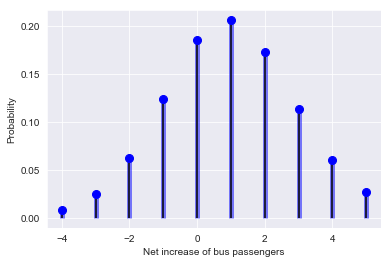

In [222]:
from scipy.stats import poisson, skellam
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

l1, l2 = 2.5, 1.5
x = np.arange(skellam.ppf(0.01, l1, l2), skellam.ppf(0.99, l1, l2))
ax.plot(x, skellam.pmf(x, l1, l2), 'bo', ms=8)
ax.vlines(x, 0, skellam.pmf(x, l1, l2), colors='b', lw=5, alpha=0.5)
rv = skellam(l1, l2)
ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1.5)
ax.set_xlabel('Net increase of bus passengers')
ax.set_ylabel('Probability')

Using this distribution we can see that we expect to net one additional passenger at this stop with a probability a little over 20%, while the probability of having more passengers getting off the bus than coming on is:

In [223]:
# we simply add the pmf for values less than 0. 
round(sum([skellam.pmf(k, l1, l2) for k in [-100,-1]]),2)

0.12

## Skellam regression

What happens when the distribution parameters are not constant but they depend on other covariates? In this case the actual distribution will depend on these covariates. This is not different than the case of a logistic regreesion, where the Binomial distribution describing the dependent variable depends on the model covariates. The goal here is not to go into the theory of [Generalized Linear Models](https://en.wikipedia.org/wiki/Generalized_linear_model), but rather to show how you can build a Skellam regression in Python. The built-in functions support several families of GLMs but not Skellam. 

While one could built two separate GLMs for the two Poisson distributions that generate the Skellam distribution, this would not be appropriate for distributions that are not independent. On the contrary modeling directly the difference of the distributions does not have this problem, since the Skellam distribution [does not depend on the correlation between the two Poisson distributions](https://www.ncbi.nlm.nih.gov/pubmed/20256640).

These type of models are usually solved through [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation). In particular, we define the likelihood function $\mathcal{L}(\mathbf{p})$ (usually the log-likelihood is used, $\log(\mathcal{L}(\mathbf{p})$) and identify parameters $\mathbf{p}$ that maximize this likelihood for the training data to have been observed under our model. 

${\bf Generate~ data:}$ We begin by generating synthetic data that capture the difference between two counts (e.g., passengers on and off the bus) whose expected value depends (linearly) on a covariate $x$ and are Poisson distributed. 

In [224]:
import random
import scipy.stats as stats
import pandas as pd

N = 10000
# x is a covariate that "dictates" the expected number of passengers on and off the bus (e.g., the )
x = np.array([random.uniform(0.1,5) for _ in range(N)])
# generate the distribution parameters through a linear function of the independent variable x 
l1 = 3*x
l2 = 8*x
# generate the dependent variable (e.g., net increase in bus load) using the Skellam distribution
y = [stats.skellam.rvs(l1[i],l2[i]) for i in range(N)]

df = pd.DataFrame({'x': list(x), 'y': y})
df.head()

,x,y
0,1.338802,-8
1,4.211756,-20
2,1.760770,-10
3,4.752165,-32
4,3.868608,-3


Essentially now we have a dataset where the dependent variabe $y$ is Skellam-distibuted (e.g., the net increase in the load capacity) and we have an independent variable $x$. In order to be able to make prediction we need to create a Skellam regression, where the distribution parameters will depend (linearly) on the covariate. 

${\bf Likelihood~function: }$We begin by defining the likelihood function. This function takes as input the currently estimated parameters of the model (intercepts and slopes), and estimates the negative log-likelihood. We will pass this function, along with initial estimates of the parameters, to the minimization function to obtain the solution: 

In [225]:
def MLESkellamRegression(params):
    # params is a vector that stores the parameters to be learned 
    int1, int2, beta1, beta2 = params[0], params[1] , params[2], params[3] 
    l1 = int1 + beta1*x
    l2 = int2 + beta2*x
    # compute the log PMF of the observed Skellam-distributed values of the dependent variable y
    # we use the exponential to make sure that parameters mu1 and mu2 are non-negative 
    negLL = -np.sum( stats.skellam.logpmf(y, mu1=np.exp(l1), mu2 = np.exp(l2), loc = 0) )
    # return negative LL
    return(negLL)

${\bf Solve~the~optimization~problem: }$ We will use the minimization function in scipy to obtain the solution to our likelihood problem. We will input an initial estimate for the parameters and let the function do its magic. 

In [226]:
from scipy.optimize import minimize

# initial estimate 
x0 = np.array([1,1,1,1])

results = minimize(MLESkellamRegression, x0, method = "Nelder-Mead", options={'disp': True})

Optimization terminated successfully.
         Current function value: 30534.836798
         Iterations: 220
         Function evaluations: 368


${\bf Evaluation:}$We now will see how well the learnt model can predict out-of-sample. We will generate a test-set with the same process as above (it would be exactly the same if we had generated more data above and simply removed some for the training). We will then explore how the expected value and the distribution of the prediction from our GLM fares with the actual values observed. 

In [227]:
x_test = np.array([random.uniform(0.1,5) for _ in range(1000)])
y1_test = 3*x_test
y2_test = 8*x_test
y_test = [stats.skellam.rvs(y1_test[i],y2_test[i]) for i in range(1000)]

df_test = pd.DataFrame({'x_test':list(x_test), 'y_test':y_test})
df_test.head()

,x_test,y_test
0,0.323249,-2
1,2.641743,-13
2,0.623779,-4
3,0.275172,-1
4,3.753940,-15


In [228]:
# predictions for the Skellam distribution parameters 
y1_hat = [np.exp(results.x[0] + results.x[2]*x_test[i]) for i in range(1000)]
y2_hat = [np.exp(results.x[1] + results.x[3]*x_test[i]) for i in range(1000)]
y_hat = list(np.array(y1_hat) - np.array(y2_hat))

The code above uses the trained model to predict the two parameters of the Skellam distribution. Given that the expected value of a variable $X\sim Skellam(\lambda_1, \lambda_2)$ is $E[X] = \lambda_1 - \lambda_2$, we can use $\hat y$ as our prediction. The following graph shows the predicted and the actual values for the dependent variable: 

The RMSE of the predictions is:  5.2933452940021315


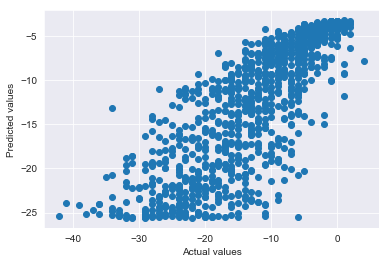

In [229]:
from sklearn.metrics import mean_squared_error
from math import sqrt

plt.scatter(y_test,y_hat)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")

print("The RMSE of the predictions is: ", sqrt(mean_squared_error(y_test, y_hat)))

As we can see there is a strong relationship between the predicted and actual values, even though the RMSE is around 5.2 (every time you run the notebook you will get slightly different results). In order to understand this, we need to remember the problem setting. We have a variable that follows a Skellam distribution with parameters that depend on some covariate(s). What we observe in the dataset (the dependent variable) is a single value from that Skellam distribution. The variance of $X\sim Skellam(\lambda_1, \lambda_2)$ is given by $var(X) = \lambda_1 + \lambda_2$. Hence, the single value we observe for every distribution will have <I>significant</I> spread around the mean (which will be our prediction). Considering the true distribution for each data point in the test set the <I>average variance</I> in these distributions is: 

In [230]:
np.mean([sqrt(y1_hat[i]+y2_hat[i]) for i in range(1000)])

5.759713592082268

If we focus on the expected value of the ground truth and predicted distributions then as we can see from the following figure the predicted values follow very closely the actual ones. 

Text(0, 0.5, 'Predicted values')

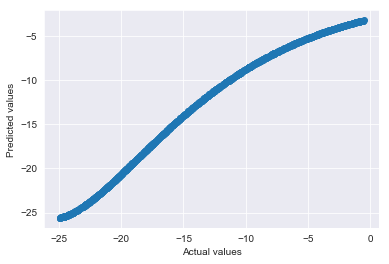

In [231]:
plt.scatter(y1_test-y2_test,y_hat)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")

We can also perform a [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test) for the gournd truth and predicted distributions at every test point and test they hypothesis that the two distributions are the same. In particular, for each test point we build a random sample distributed according to the corresponding Skellam parameters. As we can see below the majority 

The median p-value is:  0.3584201320245688
The null hypothesis can be rejected at the 5% level for:  0.17 of the cases.


[Text(0.5, 0, 'p-values')]

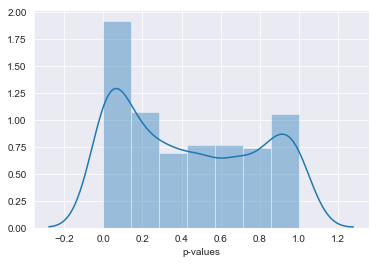

In [234]:
pvals = [stats.ks_2samp(stats.skellam.rvs(y1_test[i],y2_test[i],size = 50),stats.skellam.rvs(y1_hat[i],y2_hat[i],size = 50)).pvalue for i in range(1000)]
print("The median p-value is: ", np.median(pvals))
print("The null hypothesis can be rejected at the 5% level for: ", len([i for i in pvals if i<0.05])/len(pvals) , "of the cases.")

import seaborn as sns

ax = sns.distplot(pvals)
ax.set(xlabel='p-values')


{\bf Takeaway: }Overall the above basic script can help you built a generalized linear model beyond the ones that currently are available on the various relevant libraries. 